# Fourier Filtering
In this notebook, we will be doing simple filtering operations in an image's Fourier space and observing the results. Let's load the caeraman image and compute the fast Fourier transform. We will explore what the FFT is later, for now imagine it generates a Fourier transform of the image.

In [149]:
##load cameraman image
import numpy as np
from skimage import data

image = data.camera()
#image = image.astype(np.float32) #ensure float values

We now take the FFT of the image and shift the orgin to the center. The shifting to the center is for our benefit only, so we can visualise it better. It is a common operation, so there is a built in function for it.

In [150]:
import scipy.fftpack as fftpack

#compute the FFT
fftImage = fftpack.fft2(image) #2D FFT
fftImage = fftpack.fftshift(fftImage) #shift to the center of space for viewing
powerSpect = np.abs(fftImage) #compute absolute magnitude

We now create the actual filters for the job. We will create two masks, one that keeps the low frequencies at a certain distance from the origin (low pass filter) and another that keeps only the high frequencies furthest from the origin beyond a certain distance. The size of the filters is adjusted by the variable radius.

In [151]:
r, c = image.shape
print(image.shape)
N = r
radius = N/8.0
print("radius:", radius)
centerX = r/2
centerY = c/2

#create pass filters
lowPassFilter = np.zeros((r,c))
highPassFilter = np.zeros((r,c))
for indexX, row in enumerate(image):
    for indexY, column in enumerate(image):
        xValue = int(indexX-centerX) #center the index
        yValue = int(indexY-centerY) #center the index
        if (xValue**2 + yValue**2) <= radius**2: #within certain distance
            lowPassFilter[indexX, indexY] = 1.0 #keep low freqs
        else:
            highPassFilter[indexX, indexY] = 1.0 #else keep high freqs

(512, 512)
radius: 64.0


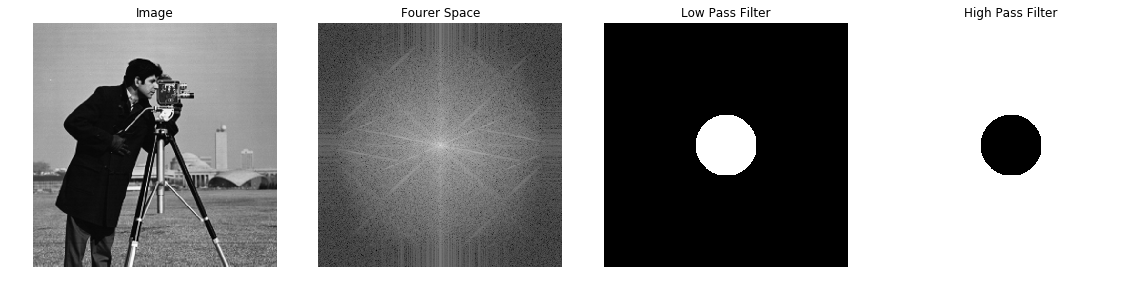

In [152]:
#plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 10))

plt.gray()
plt.tight_layout()

ax[0].imshow(image, interpolation="nearest")
ax[0].axis('off')
ax[0].set_title('Image')
ax[1].imshow(np.log10(powerSpect), interpolation="nearest")
ax[1].axis('off')
ax[1].set_title('Fourer Space')
ax[2].imshow(lowPassFilter, interpolation="nearest")
ax[2].axis('off')
ax[2].set_title('Low Pass Filter')
ax[3].imshow(highPassFilter, interpolation="nearest")
ax[3].axis('off')
ax[3].set_title('High Pass Filter')

plt.show()

Apply the filters to the image via a multiplication in Fourier space. This effectively masks the Fourier coefficients outside the filter range.

In [153]:
#apply low pass
lowFFTImage = fftImage * lowPassFilter
powerSpectLow = np.abs(lowFFTImage) #compute absolute magnitude

#inverse FFT to reconstruction image from filtered Fourier space
#compute the iFFT of original unfiltered image
ifftImage = fftpack.ifft2(fftImage) #2D FFT
ifftImage = fftpack.ifftshift(ifftImage) #shift to the center of space for viewing
#compute the iFFT of low pass filtering
lowFFTImage = fftpack.fftshift(lowFFTImage) #shift to the center of space for viewing
ifftLowImage = fftpack.ifft2(lowFFTImage) #2D FFT

D:\WinPython-64bit-3.5.4.1Qt5\python-3.5.4.amd64\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


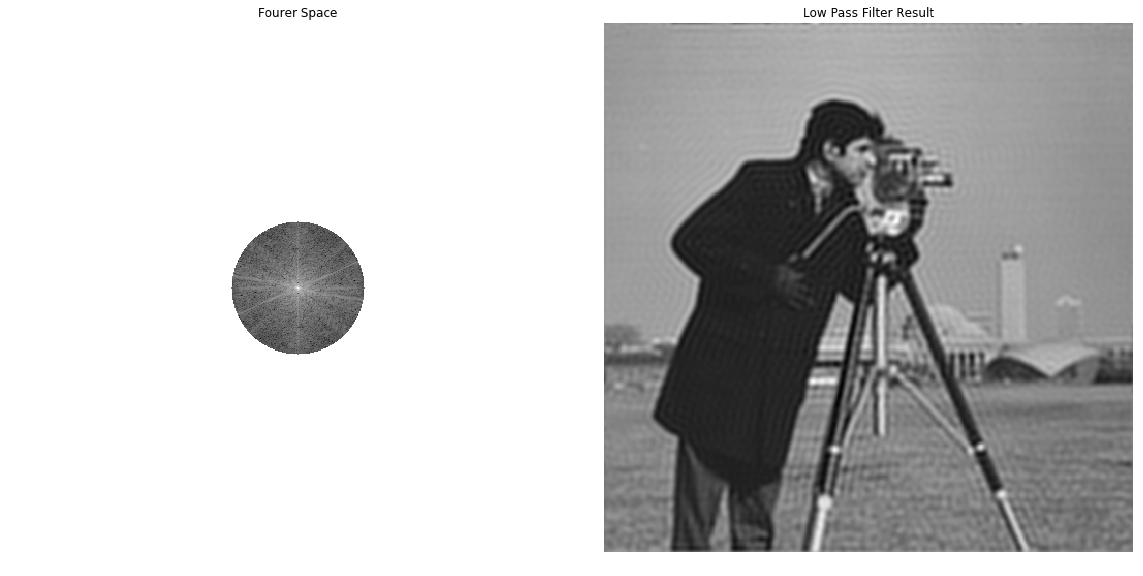

In [154]:
#plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

plt.gray()
plt.tight_layout()

ax[0].imshow(np.log10(powerSpectLow), interpolation="nearest")
ax[0].axis('off')
ax[0].set_title('Fourer Space')
ax[1].imshow(np.real(ifftLowImage), interpolation="nearest")
ax[1].axis('off')
ax[1].set_title('Low Pass Filter Result')

plt.show()

In [155]:
#apply high pass
highFFTImage = fftImage * highPassFilter
powerSpectHigh = np.abs(highFFTImage) #compute absolute magnitude

#compute the iFFT of high pass filtering
highFFTImage = fftpack.fftshift(highFFTImage) #shift to the center of space for viewing
ifftHighImage = fftpack.ifft2(highFFTImage) #2D FFT

D:\WinPython-64bit-3.5.4.1Qt5\python-3.5.4.amd64\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


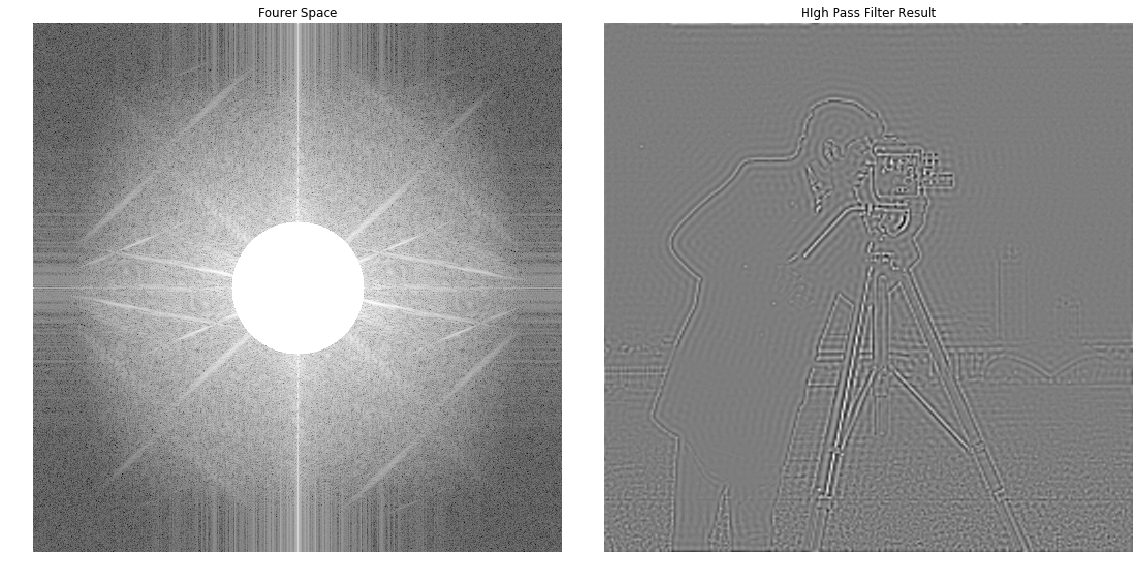

In [156]:
#plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

plt.gray()
plt.tight_layout()

ax[0].imshow(np.log10(powerSpectHigh), interpolation="nearest")
ax[0].axis('off')
ax[0].set_title('Fourer Space')
ax[1].imshow(np.real(ifftHighImage), interpolation="nearest")
ax[1].axis('off')
ax[1].set_title('HIgh Pass Filter Result')

plt.show()

Notice the Gibb's ring artefacts on both filtered results. The low pass acts like a smooth filter and the high pass like an edge detector. These are crude versions of these filters. In later lectures you will learn how to do them properly and minimise the artefacts.

We know that the window filter or the rect filter produces a sinc function, so this could be why there is the rippling artefacts. Can we minimise these artefacts using a more gradual filter that has a slow tapering off near the ends? Let's try this using one such function called the Hamming window

In [157]:
M = 2
windowSize = int(N/M)
highWindow = False
hamming = np.hamming(windowSize)
hamming2DFilter = np.sqrt(np.outer(hamming,hamming))
#invert it to create a high pass window?
value = 0.0
if highWindow:
    hamming2DFilter = 1.0-hamming2DFilter
    value = 1.0
#pad it by M to control the amount of low pass windowing
hamming2DFilter = np.pad(hamming2DFilter, (int(windowSize/2), int(windowSize/2)), mode='constant', constant_values=value)

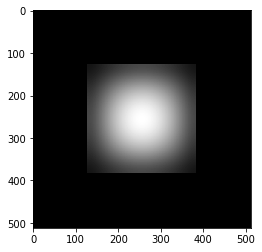

In [158]:
plt.imshow(hamming2DFilter)
plt.show()

In [159]:
#reapply low pass using the Hamming window
hamFFTImage = fftImage * hamming2DFilter
powerSpectHam = np.abs(hamFFTImage) #compute absolute magnitude

#inverse FFT to reconstruction image from filtered Fourier space
#compute the iFFT of low pass filtering
hamFFTImage = fftpack.fftshift(hamFFTImage) #shift to the center of space for viewing
ifftHammingImage = fftpack.ifft2(hamFFTImage) #2D FFT

D:\WinPython-64bit-3.5.4.1Qt5\python-3.5.4.amd64\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


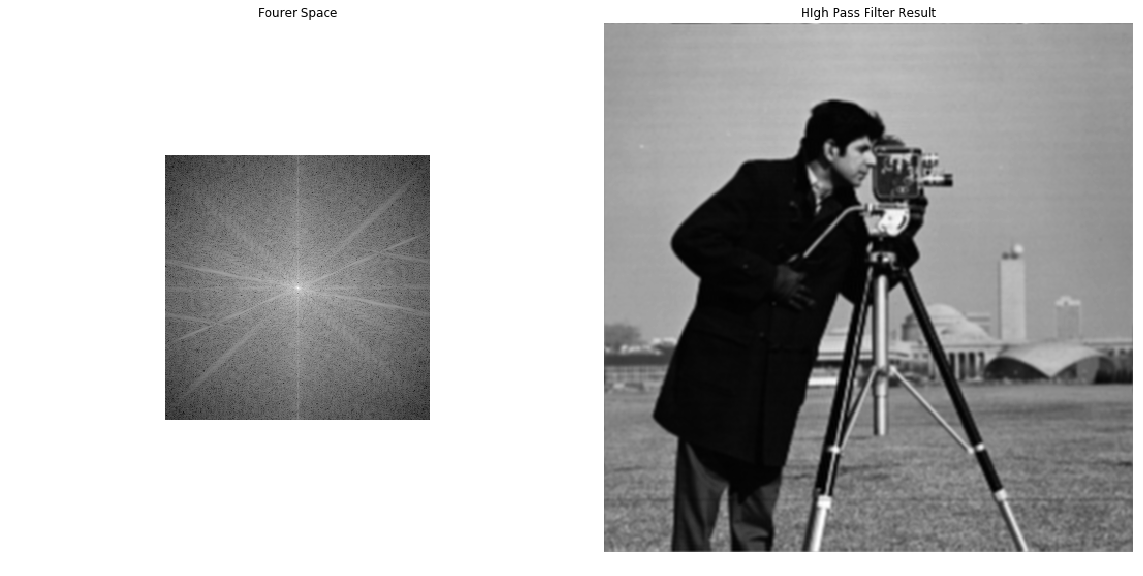

In [160]:
#plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

plt.gray()
plt.tight_layout()

ax[0].imshow(np.log10(powerSpectHam), interpolation="nearest")
ax[0].axis('off')
ax[0].set_title('Fourer Space')
ax[1].imshow(np.real(ifftHammingImage), interpolation="nearest")
ax[1].axis('off')
ax[1].set_title('HIgh Pass Filter Result')

plt.show()

Compare the result side by side with the original image

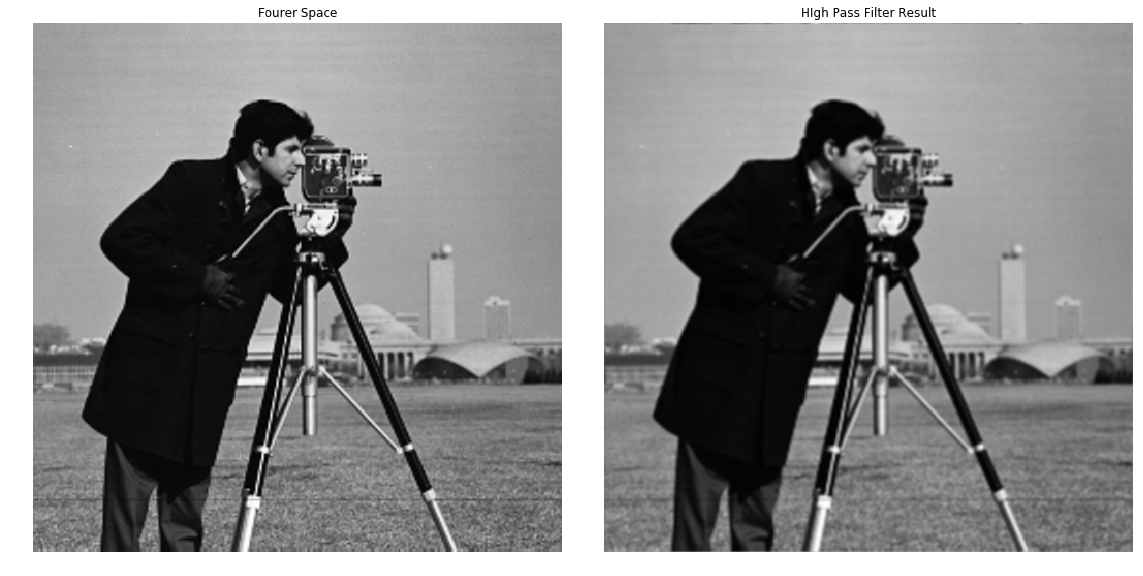

In [161]:
#plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

plt.gray()
plt.tight_layout()

ax[0].imshow(image, interpolation="nearest")
ax[0].axis('off')
ax[0].set_title('Fourer Space')
ax[1].imshow(np.real(ifftHammingImage), interpolation="nearest")
ax[1].axis('off')
ax[1].set_title('HIgh Pass Filter Result')

plt.show()

Ahhhh much better.